## Install and Includes

In [1]:
! pip install torch nltk transformers
# ! pip uninstall transformers -y
# ! pip install transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import random
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

/opt/miniconda3/envs/lab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-12 15:47:30.090134: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download([
     "names",
     "stopwords",
     "vader_lexicon",
])

[nltk_data] Downloading package names to /Users/robrohan/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robrohan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/robrohan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Load Dataset

WELFake_Dataset input format

- Serial number (starting from 0);
- Title (about the text news heading);
- Text (about the news content);
- Label (0 = fake and 1 = real).

Our final output format

- id
- label	(0 = false, 1 = true)
- sentiment (-1 = negative, 1 = positive)
- BERT embeddings:
    - e0	e1	e2	e3	e4	e5	...	e118	e119	e120	e121	e122	e123	e124	e125	e126	e127


In [4]:
df = pd.read_csv('./WELFake_Dataset.csv')
df_filter = df.iloc[0:, 1:4]
df1 = df_filter.sample(3192)
print(df.shape, df1.shape)
df1.head()

(72134, 4) (3192, 3)


,title,text,label
3960,Trump tax proposal would mostly benefit New Yo...,NEW YORK (Reuters) - Nearly all of New York Ci...,0
35506,Big Business Lobby Covet Low-Skilled Foreign W...,"WASHINGTON, D. C. — The big business lobby,...",0
19288,"George Michael Died of Heart Condition, Corone...","LONDON — George Michael, the English who ...",0
53013,White House Officials Push For Kushner To Ste...,Donald Trump keeps digging himself deeper and ...,1
69937,THE CASE AGAINST SEAN PENN: Why Do Americans W...,From claiming any American who speaks out agai...,1


## Enhance with Sentiment

In [5]:
sia = SentimentIntensityAnalyzer()
df1['sentiment'] = df1['text'].apply(lambda x: sia.polarity_scores(str(x))["compound"])
## in case we have to pickup after sentiment - so we can reload
# df1.to_csv("1_with_sentiment.csv", sep=',', encoding='utf-8')

Output format
- title
- text
- label (0 = false, 1 = true)
- sentiment (Vader SentimentAnalyzer - Valence Aware Dictionary and sEntiment Reasoner; specifically attuned to sentiments expressed in social media)
    - Normalize the score to be between -1 and 1 using an alpha that approximates the max expected value (alpha = 15)
    - > The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate. [web](https://github.com/cjhutto/vaderSentiment)

In [6]:
# pickup after a colab timeout / RAM failure
# 36067... 18033... 9016
# out_index=63202
# df1 = pd.read_csv('./1_with_sentiment.csv', skiprows=out_index, nrows=9016,
#                   names=["id","title","text","label","sentiment"])
# df1.head()

## Tokenize and Encode Text

Create features from the text

In [7]:
# Set a random seed
random_seed = 42
random.seed(random_seed)

# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")
model = BertModel.from_pretrained("prajjwal1/bert-tiny")
# Future: test with normal bert and PCA?
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# model = BertModel.from_pretrained("bert-base-uncased")

statements = df1["text"].astype(str).tolist()
print(len(statements[:2][0]), statements[:2])

# Tokenize and encode text
# The function returns a dictionary containing the token IDs and attention masks
encoding = tokenizer.batch_encode_plus(
    statements,                # List of input texts
    padding=True,              # Pad to the maximum sequence length
    truncation=True,           # Truncate to the maximum sequence length if necessary
    return_tensors='pt',       # Return PyTorch tensors
    add_special_tokens=True,   # Add special tokens CLS and SEP
    max_length=512
)

display(encoding[:2])
df1.head()

2332 ['NEW YORK (Reuters) - Nearly all of New York City’s millionaires would receive big tax cuts under President Donald Trump’s proposed tax overhaul, while  more than one-third of moderate- and middle-income families would face increases, according to a government report issued on Thursday. City Comptroller Scott Stringer said Trump’s overall plan, as proposed during the Republican president’s campaign, would give more than $5 billion of tax cuts to city dwellers. But almost two-thirds of that would go to those earning more than $500,000, even though they bear just over one-half of the total tax burden.  “We already have astounding wealth gaps across the city and across the country,” Stringer told a news conference. “The Trump tax code, if implemented, would only exacerbate it.” The lower taxes for wealthier residents would be achieved through lower marginal tax rates on ordinary and capital gains income and the elimination of the alternative minimum tax (AMT). Last week, U.S. Treasu

{'input_ids': tensor([[ 101, 2047, 2259,  ..., 1037, 4171,  102],
         [ 101, 2899, 1010,  ..., 5831, 1006,  102]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]])}

,title,text,label,sentiment
3960,Trump tax proposal would mostly benefit New Yo...,NEW YORK (Reuters) - Nearly all of New York Ci...,0,0.7106
35506,Big Business Lobby Covet Low-Skilled Foreign W...,"WASHINGTON, D. C. — The big business lobby,...",0,0.8105
19288,"George Michael Died of Heart Condition, Corone...","LONDON — George Michael, the English who ...",0,-0.8730
53013,White House Officials Push For Kushner To Ste...,Donald Trump keeps digging himself deeper and ...,1,-0.8937
69937,THE CASE AGAINST SEAN PENN: Why Do Americans W...,From claiming any American who speaks out agai...,1,0.2408


## Generating Word Embeddings

In [8]:
# Generate embeddings using BERT model
with torch.no_grad():
    outputs = model(encoding["input_ids"], attention_mask=encoding["attention_mask"])
    word_embeddings = outputs.last_hidden_state
    # Result: text_embedding is a tensor of shape [batch_size, hidden_size]
    text_embedding = outputs.last_hidden_state[:, 0, :]

# Output the shape of word embeddings
print(f"Shape of Word Embeddings: {word_embeddings.shape}")
print(f"Shape of Sentence Embeddings: {text_embedding.shape}")
print(text_embedding[0])

Shape of Word Embeddings: torch.Size([3192, 512, 128])
Shape of Sentence Embeddings: torch.Size([3192, 128])
tensor([-2.7443e-01,  7.3577e-01, -4.8044e+00, -1.2117e+00,  6.9913e-02,
         6.8199e-01,  6.8254e-01,  1.4226e+00, -2.1113e-01,  1.3147e+00,
        -2.1790e-02,  1.5511e-01,  3.3051e-01,  8.8123e-01,  2.3092e+00,
        -1.7324e+00, -8.1397e-01, -6.0540e-01, -5.6416e-01,  2.2961e+00,
         1.0377e-01,  3.0228e-02,  1.1665e+00,  2.5130e-01,  1.0067e+00,
         4.3384e-01, -1.8814e-01,  1.8947e+00, -1.0024e+00, -7.6179e-01,
         7.0089e-02, -1.2378e+00, -1.7956e+00, -1.1075e-01,  2.2283e-02,
        -1.3976e+00, -2.5525e-02,  2.7553e-01, -1.0835e+00, -1.6149e-01,
        -8.4638e-02,  6.0622e-01,  5.4877e-01, -2.7822e+00, -1.0231e+00,
        -2.2295e+00,  2.1923e-02, -8.6232e-02, -2.4463e-01,  6.2737e-01,
         1.4195e+00,  2.0402e+00,  1.8997e-01,  4.4076e-01, -1.2623e+00,
         2.4045e-01, -6.9486e-01, -9.1713e-01,  1.3708e+00,  2.3345e+00,
         3.0250

## Save Embeddings for Model Training

In [9]:
# Convert sentence embeddings to a list of lists
embeddings_list = text_embedding.cpu().numpy().tolist()
# Create a DataFrame from the embeddings
embeddings_df = pd.DataFrame(embeddings_list)
# Concatenate the embeddings DataFrame with the original DataFrame
df_with_embeddings = pd.concat([df1.reset_index(drop=True), embeddings_df], axis=1)
# Rename the columns to e_0 - e_127
embedding_columns = [f'e{i}' for i in range(embeddings_df.shape[1])]
df_with_embeddings.columns = list(df1.columns) + embedding_columns
df_with_embeddings.head()

,title,text,label,sentiment,e0,e1,e2,e3,e4,e5,...,e118,e119,e120,e121,e122,e123,e124,e125,e126,e127
0,Trump tax proposal would mostly benefit New Yo...,NEW YORK (Reuters) - Nearly all of New York Ci...,0,0.7106,-0.274427,0.735768,-4.804428,-1.211664,0.069913,0.681993,...,0.002861,-0.321664,-0.619089,0.480357,-0.016893,1.982940,-0.870989,-0.487139,-2.177910,1.224434
1,Big Business Lobby Covet Low-Skilled Foreign W...,"WASHINGTON, D. C. — The big business lobby,...",0,0.8105,-0.018459,1.069933,-4.829080,-0.475398,0.681426,0.045564,...,0.821960,0.797046,-0.371444,0.824443,-0.215496,1.098737,-0.411315,-2.902571,-0.993429,1.849544
2,"George Michael Died of Heart Condition, Corone...","LONDON — George Michael, the English who ...",0,-0.8730,-0.312890,-0.210655,-5.107797,-0.849704,-0.533000,1.338160,...,-0.818095,0.262462,0.429300,0.364661,0.237423,0.284840,-1.333650,-1.389192,-1.752405,1.060920
3,White House Officials Push For Kushner To Ste...,Donald Trump keeps digging himself deeper and ...,1,-0.8937,-0.331314,-0.812958,-4.456887,-0.675670,-0.411587,-0.344010,...,0.468594,0.517948,-0.667783,0.730071,-0.207419,0.998120,-0.670808,-0.445010,-3.145471,2.181032
4,THE CASE AGAINST SEAN PENN: Why Do Americans W...,From claiming any American who speaks out agai...,1,0.2408,-0.839796,-1.464334,-4.268298,-1.136231,-0.108371,-0.872246,...,-0.014544,0.685495,-1.177359,-0.139121,-0.262677,0.973729,-1.476357,0.014388,-2.231383,2.096414


In [10]:
# Save dataset to use with our model in matlab
model_input = df_with_embeddings.drop(['title', 'text'], axis=1)
out_index = 0
model_input.to_csv(f"2_model_input_{out_index}.csv", sep=',', encoding='utf-8')

## Visualize Embeddings

In [11]:
if not False:
  embed = df_with_embeddings.loc[:, 'e0':'e127']
  tsne = TSNE(n_components=3, perplexity=15, random_state=42, init='random', learning_rate=200)
  sentence_embeddings_2d = tsne.fit_transform(embed)

/opt/miniconda3/envs/lab/lib/python3.11/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [12]:
tbl = {'true': 1, 'false': 0}
clr = {'1': 'green', '0': 'red' }

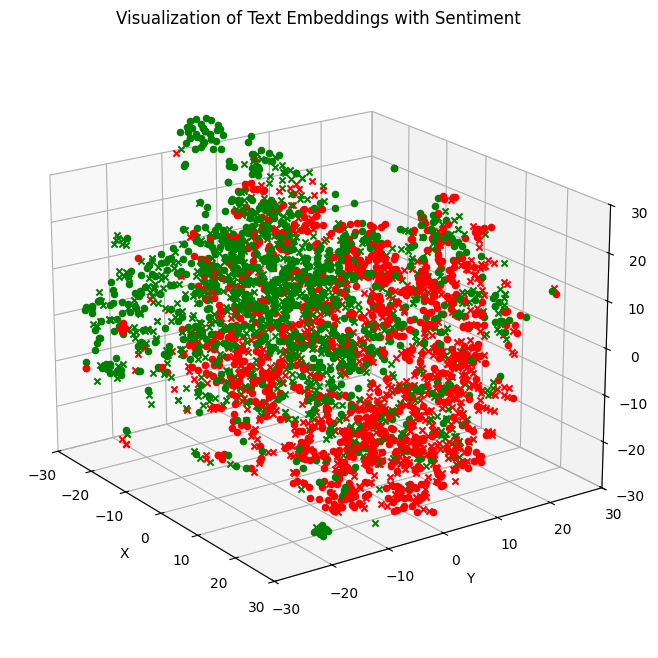

In [ ]:
if not False:
  fig = plt.figure(figsize=(15, 8))
  ax = fig.add_subplot(111, projection='3d')

  for i, row in enumerate(sentence_embeddings_2d):
      colour = clr[str(df_with_embeddings.loc[i, 'label'])]
      maker = 'o' if df_with_embeddings.loc[i, 'sentiment'] >= 0 else 'x'
      ax.scatter(row[0], row[1], row[2], c=colour, marker=maker)

  ax.set_title('Visualization of Text Embeddings with Sentiment')
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')

  ax.view_init(elev=20, azim=-35)
  ax.set_xlim([-30, 30])
  ax.set_ylim([-30, 30])
  ax.set_zlim([-30, 30])

  plt.show()